In [ ]:
!pip install pycocotools

In [43]:
from pycocotools.coco import COCO
from collections import defaultdict, Counter
import pprint
import random
import copy
import os
import shutil
import re

In [44]:
# paths
annFile='/home/ec2-user/SageMaker/sagemaker_examples/coco2017/annotations/instances_train2017.json'
dataDir = '/home/ec2-user/SageMaker/sagemaker_examples/coco2017/'
targetDataDir = '/home/ec2-user/SageMaker/sagemaker_examples/coco_samples/'

In [45]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=17.07s)
creating index...
index created!


In [46]:
images = coco.dataset['images']
annotations = coco.dataset['annotations']
print(annotations[0])

{'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}


In [47]:
image_bboxes = defaultdict(list)
num_bboxes_to_images = defaultdict(list)

for ann in annotations:
    image_bboxes[ann['image_id']].append(ann['bbox'])

for img_id in image_bboxes:
    num_bboxes_to_images[len(image_bboxes[img_id])].append(img_id)

In [48]:
Xs = []
ys = []
for num_boxes in num_bboxes_to_images:
    for img in num_bboxes_to_images[num_boxes]:
        Xs.append(img)
        ys.append(num_boxes)

In [49]:
# stratified sampling based on above distribution
from sklearn.model_selection import train_test_split

In [50]:
# X_test will contain a stratified sample of desired size
TOTAL_SAMPLES=100
test_fraction=TOTAL_SAMPLES/len(Xs)
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=test_fraction, random_state=17)

<AxesSubplot:ylabel='Density'>

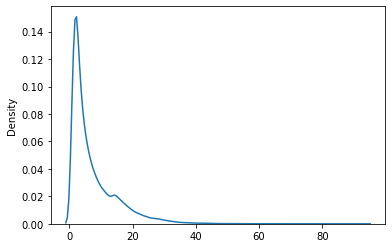

In [51]:
# plot distribution of bboxes
import seaborn as sns
sns.kdeplot(ys)

<AxesSubplot:ylabel='Density'>

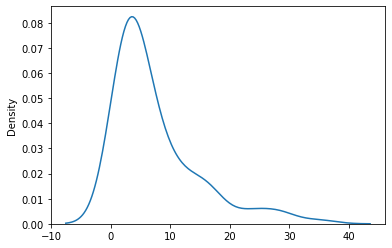

In [52]:
sns.kdeplot(y_test)

In [53]:
image_id_to_detail_map = {}
for image in images:
    image_id_to_detail_map[image['id']] = image

In [54]:
# create a mini dataset
new_annotations = []
new_images = []
new_categories = copy.deepcopy(coco.dataset['categories'])
ONLY_GEN_ANNS = False

for img_id in X_test:
    annIds = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(annIds)

    # add to new_images
    dup_image_details = copy.deepcopy(image_id_to_detail_map[img_id])
    dup_image_details['id'] = img_id
    orig_filename = dup_image_details['file_name']
    dup_image_details['file_name'] = re.sub('(?P<zeros>00*)[^0][0-9]+', r'\g<zeros>{}'.format(img_id), orig_filename)
    print(dup_image_details)
    if not ONLY_GEN_ANNS:
        # make a copy of original image
        src = os.path.join(dataDir, 'train2017', orig_filename)
        dest = os.path.join(targetDataDir, 'train2017', dup_image_details['file_name'])
        shutil.copy(src, dest)
    new_images.append(dup_image_details)
    dup_img_anns = copy.deepcopy(anns)
    # add to new_annotations
    new_annotations.extend(dup_img_anns)

dbg.close()

sampled_coco_dict = {}
sampled_coco_dict['images'] = new_images
sampled_coco_dict['categories'] = new_categories
sampled_coco_dict['annotations'] = new_annotations

import json
json.dump(sampled_coco_dict, open(os.path.join(targetDataDir, 'annotations.json'), 'w'), indent=4)


{'license': 4, 'file_name': '000000051027.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000051027.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-16 15:22:29', 'flickr_url': 'http://farm8.staticflickr.com/7153/6550981671_e6b0f0147e_z.jpg', 'id': 51027}
{'license': 3, 'file_name': '000000476904.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000476904.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 17:38:47', 'flickr_url': 'http://farm3.staticflickr.com/2275/2022325858_59b442f91c_z.jpg', 'id': 476904}
{'license': 4, 'file_name': '000000487796.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000487796.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 16:44:15', 'flickr_url': 'http://farm7.staticflickr.com/6048/6363897179_8bcce5071d_z.jpg', 'id': 487796}
{'license': 4, 'file_name': '000000215191.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000215191.jpg', 'height': 480, 'width': 640, 'da